# Data science challenge for Ultimate Technologies Inc.

This is my notebook for a Springboard practice takehome.  This takehome is for a hypothetical company, Ultimate Technologies Inc., which is similar to an Uber or a Lyft.

This notebook covers two of the takehome's three parts.  Specifically, 

* Part 1 - Explore login patters
* Part 3 - Predict retained riders

# Set up

In [1]:
# Import key libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set some defaults for Seaborn
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('muted')

# Import statsmodels modules
from statsmodels.tsa.seasonal import seasonal_decompose

# Import other libraries
import json
import datetime

# mport sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
# Eliminate warnings on final run
import warnings
warnings.simplefilter(action='ignore')

# Part 1 - Explore logins

## Load logins

In [3]:
login_raw = pd.read_json('data/logins.json')

## Assess logins

In [4]:
login_raw.shape

(93142, 1)

In [5]:
login_raw.head(5)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
login_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
login_raw.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


## Prepare logins 

In [8]:
# Create count of login every 15 minutes
temp = login_raw.copy()
temp['count'] = 1
temp = temp.groupby('login_time')['count'].sum().to_frame()
login = temp.resample('15T').sum()
login.index.rename('period', inplace=True)

In [9]:
# Add columns with month and day
login['year'] = login.index.year
login['month'] = login.index.month
login['weekday'] = login.index.dayofweek
login['hour'] = login.index.hour

In [10]:
# Add column with log(x_1) of count
login['count_log1p'] = np.log1p(login['count'])

In [11]:
# Add some rolling averages
login['roll_daily'] = login['count'].rolling(window=(4*24), center=False).mean()
login['roll_weekly'] = login['count'].rolling(window=(4*24*7), center=False).mean()
login['roll_biweekly'] = login['count'].rolling(window=(4*24*14), center=False).mean()

In [12]:
# Turn the index into a column to keep Seaborn lineplot happy
login['period_as_col'] = login.index

## Explore logins

In [13]:
print('The first date is:  {}'.format(login.index[0]))
print('The last date is:  {}'.format(login.index[-1]))

The first date is:  1970-01-01 20:00:00
The last date is:  1970-04-13 18:45:00


In [14]:
login['count'].sum()

93142

In [15]:
login['count'].describe()

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: count, dtype: float64

In [16]:
login[login['count'] == login['count'].max()]

,count,year,month,weekday,hour,count_log1p,roll_daily,roll_weekly,roll_biweekly,period_as_col
period,,,,,,,,,,
1970-03-01 04:30:00,73,1970,3,6,4,4.304065,14.8125,10.019345,10.06622,1970-03-01 04:30:00


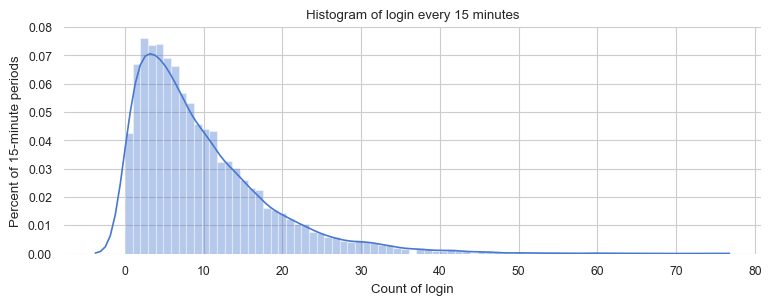

In [17]:
# Graph the distribution of login every 15 minutes
g = plt.figure(figsize=(9, 3), dpi=100)
g = sns.distplot(login['count'], bins=75, kde=True, rug=False)
g = plt.xlabel('Count of login')
g = plt.ylabel('Percent of 15-minute periods')
g = plt.title('Histogram of login every 15 minutes')
g = plt.box(on=None)

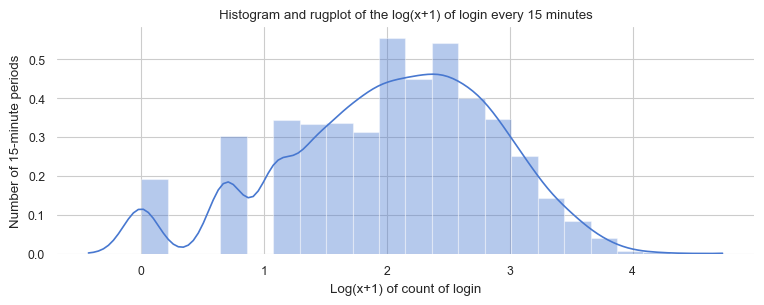

In [18]:
# Graph the distribution of log(x+1) of login every 15 minutes
g = plt.figure(figsize=(9, 3), dpi=100)
g = sns.distplot(login['count_log1p'], bins=20, kde=True, rug=False)
g = plt.xlabel('Log(x+1) of count of login')
g = plt.ylabel('Number of 15-minute periods')
g = plt.title('Histogram and rugplot of the log(x+1) of login every 15 minutes')
g = plt.box(on=None)

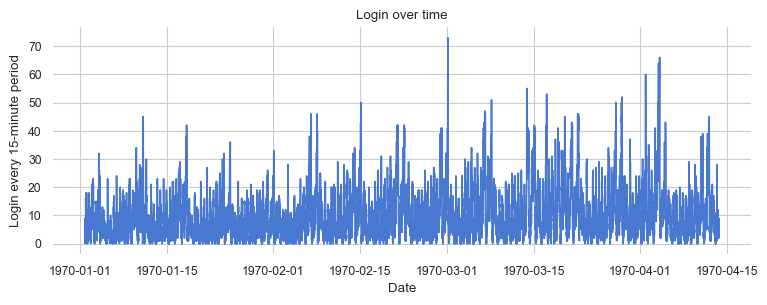

In [19]:
# Graph login across entire period
g = plt.figure(figsize=(9, 3), dpi=100)
g = sns.lineplot(data=login, x='period_as_col', y='count')
g = plt.xlabel('Date')
g = plt.ylabel('Login every 15-minute period')
g = plt.title('Login over time')
g = plt.box(on=None)

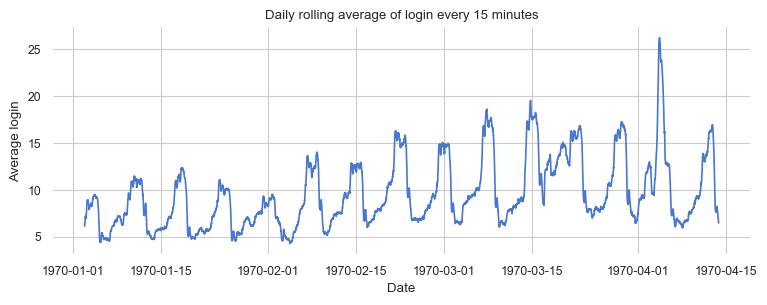

In [20]:
# Graph daily rolling average of login across entire period
g = plt.figure(figsize=(9, 3), dpi=100)
g = sns.lineplot(data=login, x='period_as_col', y='roll_daily')
g = plt.xlabel('Date')
g = plt.ylabel('Average login')
g = plt.title('Daily rolling average of login every 15 minutes')
g = plt.box(on=None)

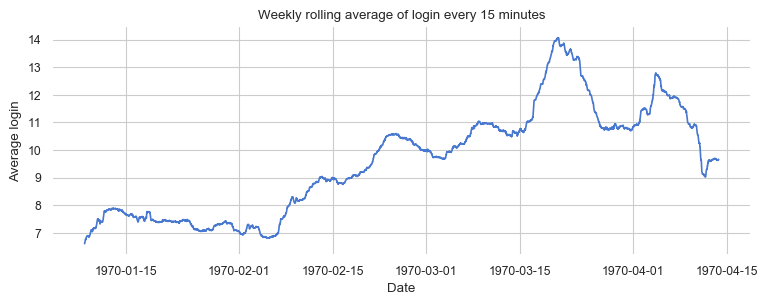

In [21]:
# Graph weekly rolling average of login across entire period
g = plt.figure(figsize=(9, 3), dpi=100)
g = sns.lineplot(data=login, x='period_as_col', y='roll_weekly')
g = plt.xlabel('Date')
g = plt.ylabel('Average login')
g = plt.title('Weekly rolling average of login every 15 minutes')
g = plt.box(on=None)

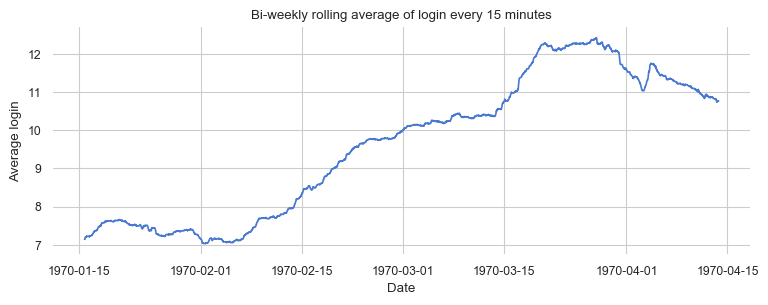

In [22]:
# Graph biweekly rolling average of login across entire period 
g = plt.figure(figsize=(9, 3), dpi=100)
g = sns.lineplot(data=login, x='period_as_col', y='roll_biweekly')
g = plt.xlabel('Date')
g = plt.ylabel('Average login')
g = plt.title('Bi-weekly rolling average of login every 15 minutes')
g = plt.box(on=None)

In [23]:
# Examine login by month
login_monthly = login.copy().pivot(columns='month', values='count')
month_names = ['Jan', 'Feb', 'Mar', 'Apr']
login_monthly.columns = month_names
login_monthly.describe()

,Jan,Feb,Mar,Apr
count,2896.000000,2688.000000,2976.000000,1228.000000
mean,7.333909,9.178943,11.331653,10.999186
std,6.099863,7.796656,9.335820,9.969840
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,4.000000,4.000000
50%,6.000000,7.000000,9.000000,8.000000
75%,10.000000,13.000000,16.000000,15.000000
max,45.000000,50.000000,73.000000,66.000000


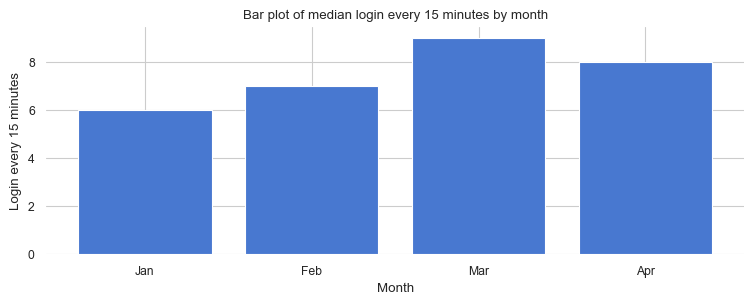

In [24]:
# Graph barplot of median login by month
login_monthly_med = pd.DataFrame(login_monthly.median())
login_monthly_med.reset_index(inplace=True)
g = plt.figure(figsize=(9, 3), dpi=100)
g = plt.bar(login_monthly_med.iloc[:, 0], login_monthly_med.iloc[:, 1], align='center')
g = plt.xlabel('Month')
g = plt.ylabel('Login every 15 minutes')
g = plt.title('Bar plot of median login every 15 minutes by month')
g = plt.box(on=None)

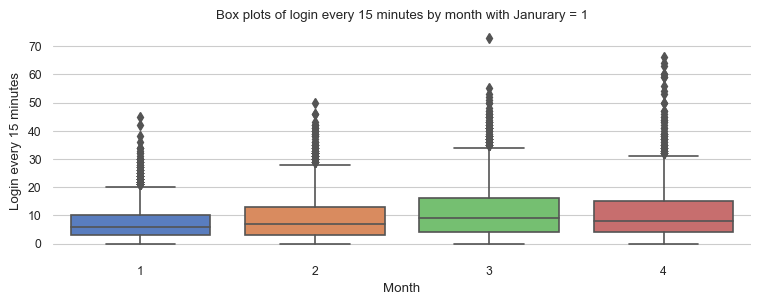

In [25]:
# Graph box plots of login by month
g = plt.figure(figsize=(9, 3), dpi=100)
g = sns.boxplot(data=login, y='count', x='month')
g = plt.xlabel('Month')
g = plt.ylabel('Login every 15 minutes')
g = plt.title('Box plots of login every 15 minutes by month with Janurary = 1')
g = plt.box(on=None)

In [26]:
# Examine login by weekday
login_weekday = login.copy().pivot(columns='weekday', values='count')
weekday_names = ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']
login_weekday.columns = weekday_names
login_weekday.describe()

,Mon,Tue,Wed,Thr,Fri,Sat,Sun
count,1420.000000,1344.000000,1344.000000,1360.000000,1440.000000,1440.000000,1440.000000
mean,6.213380,6.895833,7.692708,8.794118,10.561111,13.456250,12.615972
std,5.029465,6.264071,6.567372,7.058483,8.172082,10.357784,10.091680
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,3.000000,3.000000,5.000000,6.000000,5.000000
50%,5.000000,5.000000,6.000000,7.000000,9.000000,11.000000,10.000000
75%,8.000000,9.000000,11.000000,13.000000,15.000000,19.000000,17.000000
max,37.000000,53.000000,60.000000,45.000000,55.000000,66.000000,73.000000


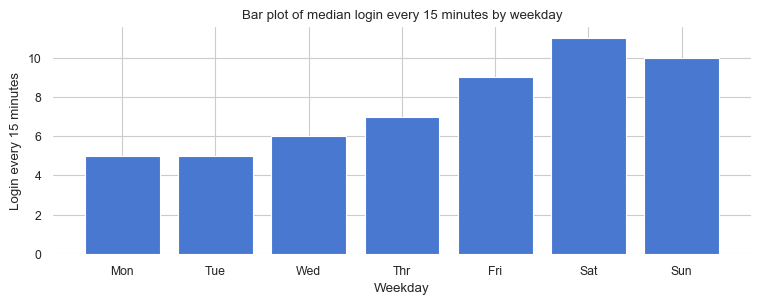

In [27]:
# Graph barplot of median login by weekday
login_weekday_med = pd.DataFrame(login_weekday.median())
login_weekday_med.reset_index(inplace=True)
g = plt.figure(figsize=(9, 3), dpi=100)
g = plt.bar(login_weekday_med.iloc[:, 0], login_weekday_med.iloc[:, 1], align='center')
g = plt.xlabel('Weekday')
g = plt.ylabel('Login every 15 minutes')
g = plt.title('Bar plot of median login every 15 minutes by weekday')
g = plt.box(on=None)

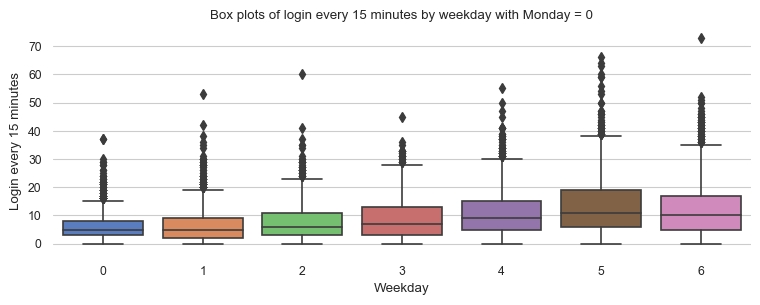

In [28]:
# Graph box plots of login by weekday
g = plt.figure(figsize=(9, 3), dpi=100)
g = sns.boxplot(data=login, y='count', x='weekday')
g = plt.xlabel('Weekday')
g = plt.ylabel('Login every 15 minutes')
g = plt.title('Box plots of login every 15 minutes by weekday with Monday = 0')
g = plt.box(on=None)

In [29]:
# Examine login by hour
login_hourly = login.copy().pivot(columns='hour', values='count')
hourly_names = ['Mdnt', '1 am', '2 am', '3 am', '4 am', '5 am', 
                '6 am', '7 am', '8 am', '9 am', '10 am', '11 am', 
                'Noon', '1 pm', '2 pm', '3 pm', '4 pm', '5 pm', 
                '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm']
login_hourly.columns = hourly_names
login_hourly.describe()

,Mdnt,1 am,2 am,3 am,4 am,5 am,6 am,7 am,8 am,9 am,...,2 pm,3 pm,4 pm,5 pm,6 pm,7 pm,8 pm,9 pm,10 pm,11 pm
count,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,...,408.000000,408.000000,408.000000,408.000000,408.000000,404.000000,408.000000,408.000000,408.000000,408.000000
mean,14.688725,15.482843,14.215686,11.840686,12.338235,7.218137,2.789216,1.997549,2.004902,3.742647,...,8.397059,7.446078,6.941176,6.333333,7.303922,8.007426,10.056373,13.781863,16.193627,14.848039
std,7.548934,9.845474,10.538221,11.317904,14.149893,9.780589,3.868182,1.709202,1.731334,2.629439,...,4.923413,5.305140,5.489903,5.162392,4.508881,5.120139,5.251817,6.804317,8.522222,7.871914
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,9.000000,8.000000,6.000000,4.000000,3.000000,1.000000,0.000000,1.000000,1.000000,2.000000,...,5.000000,4.000000,3.000000,3.000000,4.000000,4.000000,6.000000,9.000000,10.000000,9.000000
50%,14.000000,13.000000,11.000000,7.000000,5.000000,4.000000,2.000000,2.000000,2.000000,3.000000,...,7.000000,6.000000,5.000000,5.000000,6.000000,7.000000,9.000000,13.000000,15.000000,13.000000
75%,18.000000,22.000000,21.250000,18.000000,20.000000,9.000000,4.000000,3.000000,3.000000,5.000000,...,11.000000,10.000000,9.000000,8.000000,9.250000,11.000000,13.000000,17.000000,20.250000,19.000000
max,53.000000,64.000000,50.000000,47.000000,73.000000,66.000000,45.000000,12.000000,11.000000,14.000000,...,31.000000,28.000000,30.000000,33.000000,24.000000,31.000000,29.000000,45.000000,55.000000,60.000000


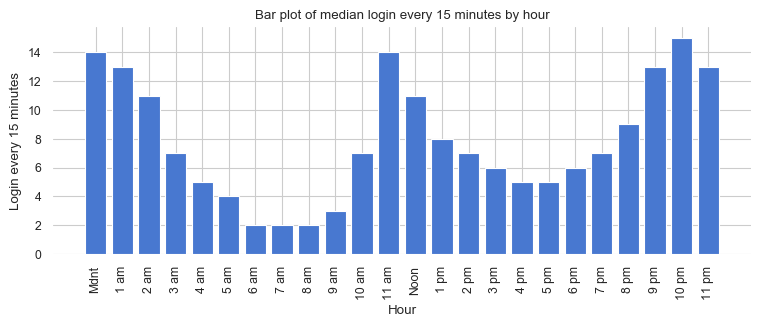

In [30]:
# Graph barplot of median login by hour
login_hourly_med = pd.DataFrame(login_hourly.median())
login_hourly_med.reset_index(inplace=True)
g = plt.figure(figsize=(9, 3), dpi=100)
g = plt.bar(login_hourly_med.iloc[:, 0], login_hourly_med.iloc[:, 1], align='center')
g = plt.xticks(rotation='vertical')
g = plt.xlabel('Hour')
g = plt.ylabel('Login every 15 minutes')
g = plt.title('Bar plot of median login every 15 minutes by hour')
g = plt.box(on=None)

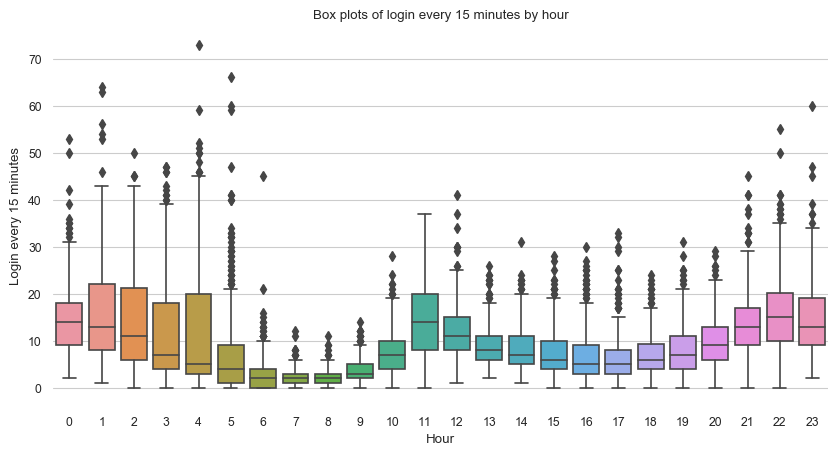

In [31]:
# Graph box plots of login by hour
g = plt.figure(figsize=(10, 5), dpi=100)
g = sns.boxplot(data=login, y='count', x='hour')
g = plt.xlabel('Hour')
g = plt.ylabel('Login every 15 minutes')
g = plt.title('Box plots of login every 15 minutes by hour')
g = plt.box(on=None)

Weekly decomposition of daily login into trend, seasonality and residual via naive, additive model


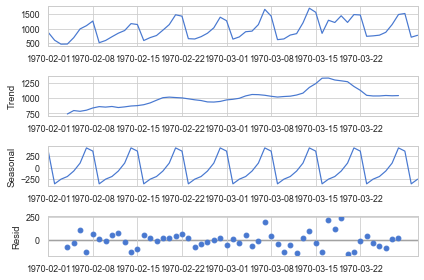

In [32]:
# Decompose weekly pattern with daily data for two month sample

# Filter out all but 2 months of data
login_decomp_day = login.copy()
login_decomp_day = login_decomp_day[(login_decomp_day.index >= '1970-02-01 00:00:00') &
                    (login_decomp_day.index < '1970-04-01 00:00:00')]

# Resample to hourly data
login_decomp_day = login_decomp_day.drop(['year', 'month', 'weekday', 'hour', 'count_log1p', 
                                  'roll_daily', 'roll_weekly', 'roll_biweekly', 'period_as_col'],
                                 axis=1)
login_decomp_day = login_decomp_day.resample('D').sum()

# Decompose daily login by week
this_period = 7
print('Weekly decomposition of daily login into trend, seasonality and residual via naive, additive model')
decompose = seasonal_decompose(login_decomp_day, model='additive', period=this_period)
g = decompose.plot()
g = plt.show()

Weekly decomposition of hourly login into trend, seasonality and residual via a naive, additive model


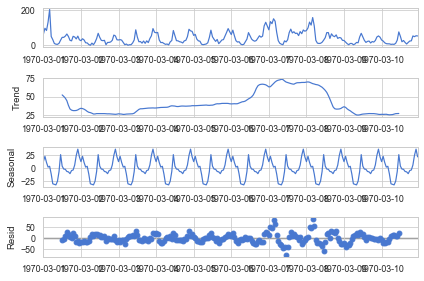

In [33]:
# Decompose daily pattern with hourly data for a 10 day sample

# Filter out all but 14 days of data
login_decomp_hourly = login.copy()
login_decomp_hourly = login_decomp_hourly[(login_decomp_hourly.index >= '1970-03-01 00:00:00') &
                    (login_decomp_hourly.index < '1970-03-11 00:00:00')]


# Resample to hourly data
login_decomp_hourly = login_decomp_hourly.drop(['year', 'month', 'weekday', 'hour', 'count_log1p', 
                                  'roll_daily', 'roll_weekly', 'roll_biweekly', 'period_as_col'],
                                 axis=1)
login_decomp_hourly = login_decomp_hourly.resample('H').sum()

# Decompose hourly login by day
this_period = 24
print('Weekly decomposition of hourly login into trend, seasonality and residual via a naive, additive model')
decompose = seasonal_decompose(login_decomp_hourly, model='additive', period=this_period)
g = decompose.plot()
g = plt.show()

# Part 3 - Predict rider retention

## Load features

In [34]:
# Use Python's json encoder and decoder to load file
# NOTE:  I get a ValueERror with Pandas read_json
file = open('data/ultimate_data_challenge.json', 'r')
features_raw = pd.DataFrame(json.load(file))
file.close()

## Assess features

In [35]:
features_raw.shape

(50000, 12)

In [36]:
features_raw.head(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [37]:
features_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## Explore features

In [38]:
features_raw.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [39]:
# Explore sign up date
print(features_raw['signup_date'].min())
print(features_raw['signup_date'].max())

2014-01-01
2014-01-31


In [40]:
# Explore last_trip_date
print(features_raw['last_trip_date'].min())
print(features_raw['last_trip_date'].max())

2014-01-01
2014-07-01


In [41]:
# Explore city
features_raw['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [42]:
# Explore phone
features_raw['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

## Prepare features

In [43]:
features = features_raw.copy()

In [44]:
# Convert _date columns to datetime
features['signup_date'] = pd.to_datetime(features['signup_date'])
features['last_trip_date'] = pd.to_datetime(features['last_trip_date'])

## Calculate retained

In [45]:
# Create a dataframe for retained
retained = features.copy()

# Set up values
NOW = pd.datetime(2014, 7, 1)
WINDOW = datetime.timedelta(days=30)

# Calc if retained for not
def calc_retained(value_last_trip_date):
    is_retained = False
    diff = (NOW - value_last_trip_date)
    if diff <= WINDOW:
        is_retained = True
    return is_retained

retained['is_retained'] = retained.apply(lambda x: calc_retained(x['last_trip_date']), axis=1)

# Drop all columns other than is_retained
to_drop = retained.columns.to_list()
to_drop.remove('is_retained')
retained.drop(to_drop, axis=1, inplace=True)

In [46]:
retained['is_retained'].value_counts()

False    31196
True     18804
Name: is_retained, dtype: int64

In [47]:
pct = round((retained['is_retained'].sum() / retained.shape[0]) * 100, 2)
print('About {}% of the January cohort is retained'.format(pct))

About 37.61% of the January cohort is retained


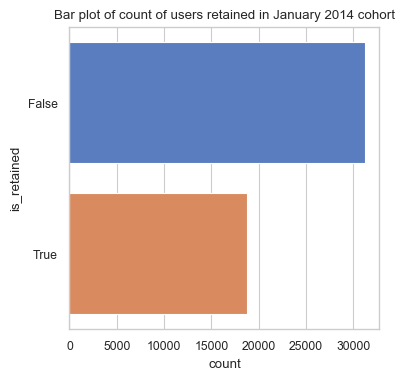

In [48]:
g = plt.figure(figsize=(4, 4), dpi=100)
g = sns.countplot(y='is_retained', data=retained)
g = plt.title('Bar plot of count of users retained in January 2014 cohort')

## Prepare for modeling

Here, I do some simple feature engineering

In [49]:
# Replace city names with numeric values
features['city'].replace({'Winterfell': 0, 'Astapor': 1, "King's Landing": 3}, inplace=True)

In [50]:
# Turn signup_date into features of signup_weekday
features['signup_weekday'] = features['signup_date'].dt.dayofweek

# Drop signup_date
features.drop(['signup_date'], axis=1, inplace=True)

In [51]:
# Fill missing values in avg_rating_of_driver with median
features['avg_rating_of_driver'].fillna(features['avg_rating_of_driver'].median(), inplace=True)

In [52]:
# Drop last_trip_date as that's related to what we're predicting
features.drop(['last_trip_date'], axis=1, inplace=True)

In [53]:
# Fill missing values in phone with most common value 
features['phone'].fillna(features_raw['phone'].value_counts().index[0], inplace=True)

# Replace phone names with numeric values
features['phone'].replace({'iPhone': 0, 'Android': 1}, inplace=True)

In [54]:
# Fill missing values in avg_rating_of_driver with median
features['avg_rating_by_driver'].fillna(features['avg_rating_by_driver'].median(), inplace=True)

In [55]:
# Fill missing values in avg_rating_of_driver with median
features['avg_rating_by_driver'].fillna(features['avg_rating_by_driver'].median(), inplace=True)

In [56]:
# Add a column of random 1's and 0's as a point of comparison
features['random'] = np.random.randint(low=0, high=2, size=features.shape[0])

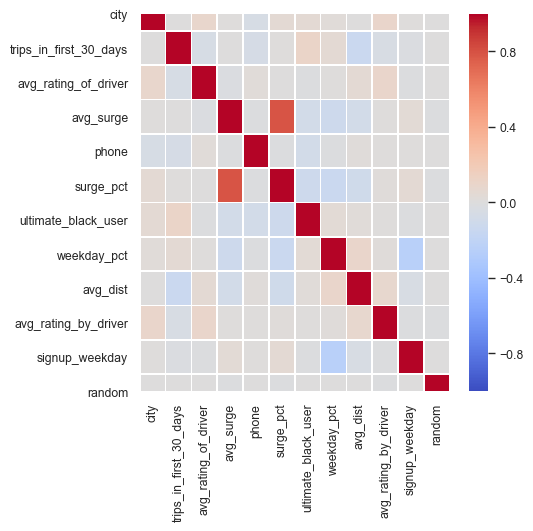

In [57]:
# Look at correlation between features
corr = features.corr().round(decimals=2)
g = plt.figure(figsize=(5, 5), dpi=100)
g = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            vmin=-1, vmax=1,
            linewidths=.5,
            cmap='coolwarm')

In [58]:
# Drop avg_surge due to its high correlation with surge_pct
features.drop(['avg_surge'], axis=1, inplace=True)

## Model adopted users with random forest

In [59]:
# Assign
y = retained
X = features

In [60]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [61]:
# Instantiate
rf = RandomForestClassifier(n_estimators=100, oob_score = True)

In [62]:
# Fit
rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True)

In [63]:
# Summarize
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [64]:
# Predict
y_pred = rf.predict(X_test)

In [65]:
# Score
print('The accuracy score is {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('The oob score {}'.format(rf.oob_score_))

The accuracy score is 0.76376
The oob score 0.7660533333333334


In [66]:
# Exmaine confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[6467 1333]
 [1620 3080]]


In [67]:
# Examine precision, recall and F1
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.83      0.81      7800
        True       0.70      0.66      0.68      4700

    accuracy                           0.76     12500
   macro avg       0.75      0.74      0.75     12500
weighted avg       0.76      0.76      0.76     12500



In [68]:
# Create summary table
rf_coeff = pd.DataFrame()
rf_coeff['features'] = X_train.columns
rf_coeff['rf_importance'] = rf.feature_importances_.round(4)
rf_coeff['rf_rank'] = rf_coeff['rf_importance'].rank(method='dense', ascending=False).astype('int32')

# Call out the magnitude of the feature's importance to the rf model
def calc_rf_magnitude(value_rf_importance):
    if value_rf_importance >= 0.1:
        size = 'higher'
    elif value_rf_importance > .05 and value_rf_importance < 0.1:
        size = 'med'
    else:
        size = 'lower'
    return size

# Create new column with the function
rf_coeff['rf_magnitude'] = rf_coeff.apply(lambda x: calc_rf_magnitude(x['rf_importance']), axis=1)

rf_coeff.sort_values(by='rf_rank', ascending=True)

,features,rf_importance,rf_rank,rf_magnitude
7,avg_dist,0.2365,1,higher
6,weekday_pct,0.1388,2,higher
8,avg_rating_by_driver,0.1223,3,higher
4,surge_pct,0.0931,4,med
0,city,0.0818,5,med
9,signup_weekday,0.0807,6,med
2,avg_rating_of_driver,0.0785,7,med
1,trips_in_first_30_days,0.0770,8,med
3,phone,0.0364,9,lower
5,ultimate_black_user,0.0319,10,lower


No handles with labels found to put in legend.


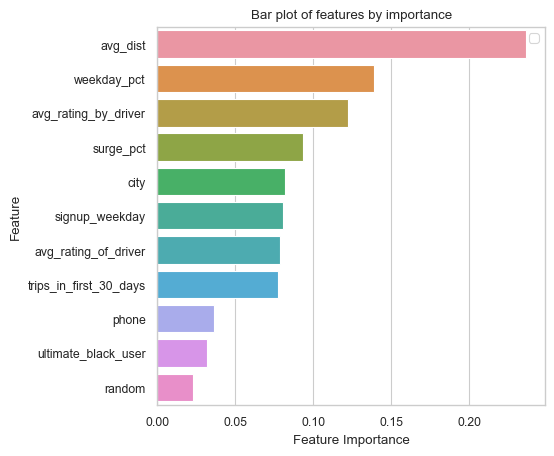

In [69]:
# Visualize feature importance
feature_imp = pd.Series(rf.feature_importances_,index=features.columns.tolist()).sort_values(ascending=False)
g = plt.figure(figsize=(5, 5), dpi=100)
g = sns.barplot(x=feature_imp, y=feature_imp.index)
g = plt.xlabel('Feature Importance')
g = plt.ylabel('Feature')
g = plt.title("Bar plot of features by importance")
g = plt.legend()